In [ ]:
!pip install crcmod
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet

!gsutil -m -o 'GSUtil:parallel_composite_upload_threshold_1M''GSUtil:sliced_object_download_max_components=8' cp -r gs://evenergy163.appspot.com/data/** .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp311-cp311-linux_x86_64.whl size=31660 sha256=98ec04914022050095413e6673dd275dd6d2aa675612df9be3471a01c5fc4212
  Stored in directory: /root/.cache/pip/wheels/23/94/7a/8cb7d14597e6395ce969933f01aed9ea8fa5f5b4d4c8a61e99
Successfully built crcmod
Copying gs://evenergy163.appspot.com/data/California Electric Rates.csv...
Copying gs://evenergy163.appspot.com/data/HS861 2010-.xlsx...
Copying gs://evenergy163.appspot.com/data/HS861M 2010-.xlsx...
Copying gs://evenergy163.appspot.com/data/evwatts.public.connector.csv...
Copying gs://evenergy163.appspot.com/data/Monthly Gas Prices.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.evse.csv...
Copying gs://evenergy163.appspot.com/data/annual_generation_state.xlsx...
Copying gs://evenergy163.appspot.com/data/evwatts.public.session.csv...
Copying gs://evenergy163.apps

In [ ]:
session_data = pd.read_csv('evwatts.public.session.csv')
evse_data = pd.read_csv('evwatts.public.evse.csv')
merged_data = pd.merge(session_data, evse_data[['evse_id', 'charge_level', 'region', 'metro_area']], on='evse_id', how='left')
session_data = merged_data

In [ ]:
session_data['start_datetime'] = pd.to_datetime(session_data['start_datetime'])
session_data['month'] = session_data['start_datetime'].dt.month
session_data['year'] = session_data['start_datetime'].dt.year
session_data.head(5)

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,charge_level,region,metro_area,month,year
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,L2,Middle Atlantic,Undesignated,3,2020
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,L2,Middle Atlantic,Undesignated,3,2020
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,L2,Middle Atlantic,"Rochester, NY Metro Area",3,2020
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",3,2020
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2,2020


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_wciaoa4/riod48dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_wciaoa4/8d_y24_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24533', 'data', 'file=/tmp/tmp_wciaoa4/riod48dw.json', 'init=/tmp/tmp_wciaoa4/8d_y24_o.json', 'output', 'file=/tmp/tmp_wciaoa4/prophet_modeldi7xbw9n/prophet_model-20250423041341.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:13:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


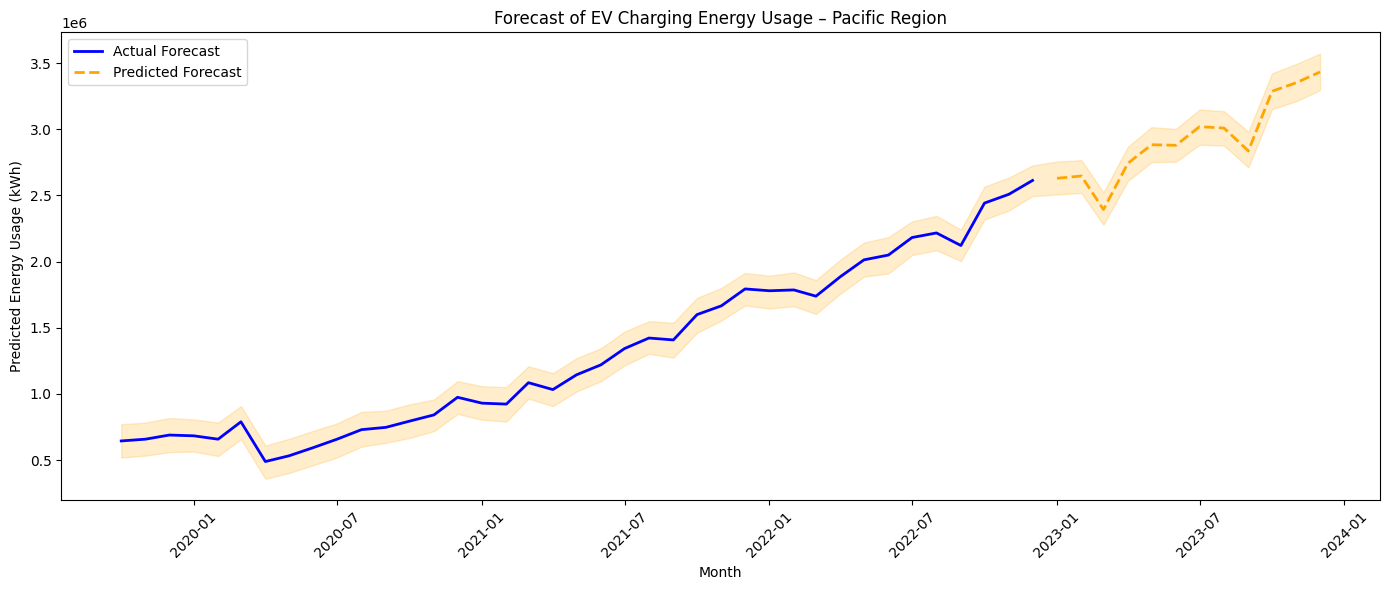

In [ ]:
# Step 1: Filter Pacific region and prepare datetime
pacific_data = session_data[session_data['region'] == 'Pacific'].copy()
pacific_data['start_datetime'] = pd.to_datetime(pacific_data['start_datetime'])
pacific_data['year_month'] = pacific_data['start_datetime'].dt.to_period('M').dt.to_timestamp()

# Step 2: Aggregate total energy per month
monthly_energy = pacific_data.groupby('year_month')['energy_kwh'].sum().reset_index()
monthly_energy.columns = ['ds', 'y']  # Prophet expects 'ds' and 'y'

# Step 3: Initialize and fit Prophet model
model = Prophet()
model.fit(monthly_energy)

# Step 4: Create future dataframe and forecast
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Step 5: Separate actual vs. forecasted part
forecast['is_forecast'] = forecast['ds'] > monthly_energy['ds'].max()

# Step 6: Plot
plt.figure(figsize=(14, 6))

# Historical forecasted trend (blue)
sns.lineplot(data=forecast[~forecast['is_forecast']], x='ds', y='yhat', label='Actual Forecast', color='blue', linewidth=2)

# Future predictions (orange dashed)
sns.lineplot(data=forecast[forecast['is_forecast']], x='ds', y='yhat', label='Predicted Forecast', color='orange', linestyle='--', linewidth=2)

# Optional: Uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='orange')

# Final plot styling
plt.title('Forecast of EV Charging Energy Usage – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Predicted Energy Usage (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()